Update :
    Ajout de DataAugmentation

In [146]:
import random

import keras
import re
import os
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D,Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dropout, Lambda
from keras.layers import concatenate
import glob

## Load model

In [147]:
model = keras.models.load_model('A:\\fingers.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [148]:
x = model.layers[-2].output

In [149]:
x

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'global_average_pooling2d')>

In [150]:
output = Dense(units=3, activation='softmax')(x)

In [151]:
model = Model(inputs=model.input, outputs=output)

In [152]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

## Load Data

In [153]:
from tqdm import tqdm
import random
def load(set: str):
    xtrain = []
    ytrain = []
    print(set)
    train_num_files = 0
    for source in ["Temps1", "Temps2", "Temps3"]:
        print(source)
        file_list = glob.glob(
            r"A:/%(s)s/images/%(set)s/*.png" % {"s": source, "set": set})
        if source == "Temps0":
            file_list = random.choices(file_list, k=200)
        # print(len(file_list))
        for file in tqdm(file_list, desc="Loading..."):
            p = 'A:/%(s)s/labels/%(set)s/' % {"s": source, "set": set}
            file_label = p + file[len(p):]
            file_label = file_label[:-4]
            file_label = file_label+'.txt'
            if os.path.isfile(file_label):
                f = open(file_label,"r+")
                a = f.read()
                if len(a)>=1:
                    im = imread(file)[:, :, :3]
                    train_num_files += 1
                    xtrain.append(im)
                    ytrain.append([int(a[0])])
                f.close()
    return xtrain, ytrain

xtrain, ytrain = load("train")
xval, yval = load("val")
xtest, ytest = load("test")
# xtest2, ytest2 = load("train", mode="choices", k=200, sources=("Temps0",))

train
Temps1


Loading...: 100%|██████████| 519/519 [00:01<00:00, 455.27it/s]


Temps2


Loading...: 100%|██████████| 448/448 [00:01<00:00, 391.97it/s]


Temps3


Loading...: 100%|██████████| 326/326 [00:00<00:00, 382.75it/s]


val
Temps1


Loading...: 100%|██████████| 54/54 [00:00<00:00, 378.63it/s]


Temps2


Loading...: 100%|██████████| 310/310 [00:00<00:00, 360.16it/s]


Temps3


Loading...: 100%|██████████| 71/71 [00:00<00:00, 389.02it/s]


test
Temps1


Loading...: 100%|██████████| 31/31 [00:00<00:00, 277.52it/s]


Temps2


Loading...: 100%|██████████| 321/321 [00:00<00:00, 339.87it/s]


Temps3


Loading...: 100%|██████████| 181/181 [00:00<00:00, 348.32it/s]


In [154]:
filepath = 'shifumi_from_mobil.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [155]:
# import tensorflow_addons as tfa

In [156]:
def f1_score(y_true, y_pred):
	def recall_m(y_true, y_pred):
		TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
		Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

		recall = TP / (Positives+K.epsilon())
		return recall


	def precision_m(y_true, y_pred):
		TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
		Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

		precision = TP / (Pred_Positives+K.epsilon())
		return precision

	precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

	return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [157]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

In [158]:
from keras.utils import to_categorical

In [159]:
xtrain = np.asarray(xtrain)
xval = np.asarray(xval)
xtest = np.asarray(xtest)
ytrain = to_categorical(ytrain)
yval = to_categorical(yval)
ytest = to_categorical(ytest)

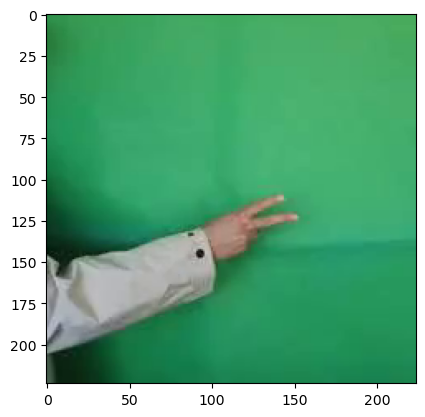

In [160]:
plt.imshow(xtrain[350])

In [161]:
import sys
sys.getsizeof(xtrain)

777326744

## Train

In [162]:

history = model.fit(xtrain, ytrain,
            # model.fit(train_gen,
            validation_data=(xval, yval),
            batch_size=10,
            steps_per_epoch=len(xtrain) // 10,
            epochs=10, verbose=1, callbacks=[callbacks])

Epoch 1/10
127/129 [============================>.] - ETA: 0s - loss: 0.5850 - accuracy: 0.7496 - f1_score: 0.7506
Epoch 1: val_loss improved from inf to 1.67206, saving model to shifumi_from_mobil.hdf5
129/129 [==============================] - 6s 35ms/step - loss: 0.5779 - accuracy: 0.7527 - f1_score: 0.7537 - val_loss: 1.6721 - val_accuracy: 0.5770 - val_f1_score: 0.5712
Epoch 2/10
128/129 [============================>.] - ETA: 0s - loss: 0.1882 - accuracy: 0.9245 - f1_score: 0.9263
Epoch 2: val_loss improved from 1.67206 to 1.26693, saving model to shifumi_from_mobil.hdf5
129/129 [==============================] - 4s 29ms/step - loss: 0.1870 - accuracy: 0.9251 - f1_score: 0.9268 - val_loss: 1.2669 - val_accuracy: 0.7333 - val_f1_score: 0.7317
Epoch 3/10
127/129 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9556 - f1_score: 0.9471
Epoch 3: val_loss improved from 1.26693 to 1.17204, saving model to shifumi_from_mobil.hdf5
129/129 [==========================

In [163]:
a = np.unique(yval, return_counts=True, axis=0)
b = np.unique(ytrain, return_counts=True, axis=0)
a, b

((array([[0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]], dtype=float32),
  array([166, 147, 122], dtype=int64)),
 (array([[0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]], dtype=float32),
  array([614, 378, 299], dtype=int64)))

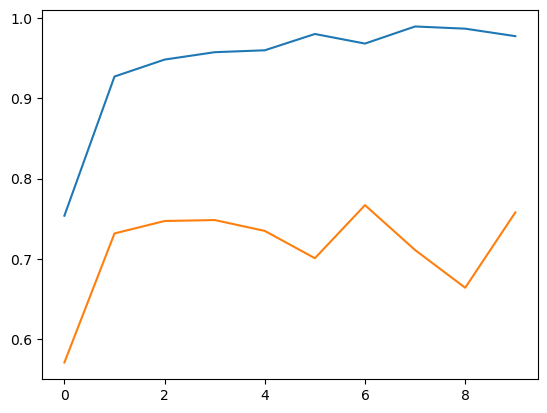

In [164]:
import matplotlib.pyplot as plt

plt.plot(history.history["f1_score"])
plt.plot(history.history["val_f1_score"])
plt.show()

In [165]:
callbacks[0].model.evaluate(xtest, ytest)

17/17 [==============================] - 1s 28ms/step - loss: 0.7146 - accuracy: 0.7861 - f1_score: 0.7894


[0.7145949602127075, 0.7861163020133972, 0.7893626689910889]